In [517]:
import pandas as pd
import json
import numpy as np
import seaborn as sn
import pickle
import xgboost as xgb

from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, mutual_info_score

In [153]:
## Loading the Dataset

In [3]:
data = 'https://raw.githubusercontent.com/aliaksandra-babova/ML-Zoomcamp-2025-Midterm-Project/refs/heads/main/play_tennis_dataset.csv'

In [4]:
!wget $data

--2025-11-18 14:07:57--  https://raw.githubusercontent.com/aliaksandra-babova/ML-Zoomcamp-2025-Midterm-Project/refs/heads/main/play_tennis_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204798 (200K) [text/plain]
Saving to: ‘play_tennis_dataset.csv.2’

play_tennis_dataset 100%[===================>] 200.00K  --.-KB/s    in 0.004s  

2025-11-18 14:07:58 (52.3 MB/s) - ‘play_tennis_dataset.csv.2’ saved [204798/204798]



In [475]:
df = pd.read_csv('play_tennis_dataset.csv')

In [476]:
df.head()

,Day,Outlook,Temperature,Humidity,Wind,Play
0,D1,Overcast,Mild,Normal,Strong,Yes
1,D2,Sunny,Mild,Normal,Strong,Yes
2,D3,NaN,Mild,High,Strong,No
3,D4,Sunny,Mild,High,Weak,Yes
4,D5,Sunny,Cool,Normal,Strong,Yes


In [477]:
## Data Cleanup

In [478]:
df.shape

(6666, 6)

In [479]:
df.isnull().sum()

Day              0
Outlook        399
Temperature    333
Humidity       233
Wind           366
Play             0
dtype: int64

In [480]:
df.dtypes

Day            object
Outlook        object
Temperature    object
Humidity       object
Wind           object
Play           object
dtype: object

In [481]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

Day
['D1' 'D2' 'D3' 'D4' 'D5']
31

Outlook
['Overcast' 'Sunny' nan 'Rainy']
3

Temperature
['Mild' 'Cool' 'Hot' nan]
3

Humidity
['Normal' 'High' nan]
2

Wind
['Strong' 'Weak' nan]
2

Play
['Yes' 'No']
2



In [482]:
# Removing the Day column as it doesn't add value

In [483]:
df = df.drop(columns = ['Day'])

In [484]:
# Making column names and values look uniform

In [485]:
df.columns = df.columns.str.lower()

categorical = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical:
    df[c] = df[c].str.lower()

In [486]:
# Filling the missing values with "unknown"

In [487]:
df.outlook = df.outlook.fillna("unknown")

In [488]:
df.temperature = df.temperature.fillna("unknown")
df.humidity = df.humidity.fillna("unknown")
df.wind = df.wind.fillna("unknown")

In [489]:
# Transforming the target variable into 0s and 1s, using "no" as 1, because 

In [490]:
df.play = (df.play == 'no').astype(int)

In [491]:
df.head()

,outlook,temperature,humidity,wind,play
0,overcast,mild,normal,strong,0
1,sunny,mild,normal,strong,0
2,unknown,mild,high,strong,1
3,sunny,mild,high,weak,0
4,sunny,cool,normal,strong,0


In [492]:
## Data preparation for regression

In [493]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [494]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [495]:
y_train = df_train.play.values
y_val = df_val.play.values
y_test = df_test.play.values

del df_train['play']
del df_val['play']
del df_test['play']

In [496]:
## EDA

In [497]:
df_full_train.play.value_counts(normalize=True)

play
0    0.615904
1    0.384096
Name: proportion, dtype: float64

In [498]:
df_full_train.play.mean()

np.float64(0.3840960240060015)

In [499]:
# Checking feature importance

In [500]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)

In [501]:
def mutual_info_play_score(series):
    return mutual_info_score(series, df_full_train.play)

In [502]:
mi = df_full_train[categorical].apply(mutual_info_play_score)
mi.sort_values(ascending=False)

temperature    0.121530
outlook        0.119611
humidity       0.040637
wind           0.033610
dtype: float64

In [503]:
# Encoding categorical variables

In [504]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [234]:
## Logistic regression

In [235]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [236]:
y_pred = model.predict_proba(X_val)[:, 1]

In [237]:
play_decision = (y_pred >= 0.5)

In [238]:
accuracy = (play_decision == y_val).mean()
accuracy

np.float64(0.900225056264066)

In [239]:
# Parameter tuning

In [240]:
for C in [0.01, 0.1, 0.5, 5, 10]:

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    play_decision = (y_pred >= 0.5)
    accuracy = (y_val == play_decision).mean()
    
    print(C, accuracy)

0.01 0.8994748687171793
0.1 0.900225056264066
0.5 0.900225056264066
5 0.900225056264066
10 0.9009752438109527


In [241]:
# Final Logistic regression model

In [242]:
model = LogisticRegression(solver='liblinear', C=0.1, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [243]:
# Model evaluation

In [244]:
dicts_test = df_test[categorical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9025487256371814
ROC-AUC: 0.9629151799891652

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       796
           1       1.00      0.76      0.86       538

    accuracy                           0.90      1334
   macro avg       0.93      0.88      0.89      1334
weighted avg       0.92      0.90      0.90      1334


Confusion Matrix:
 [[796   0]
 [130 408]]


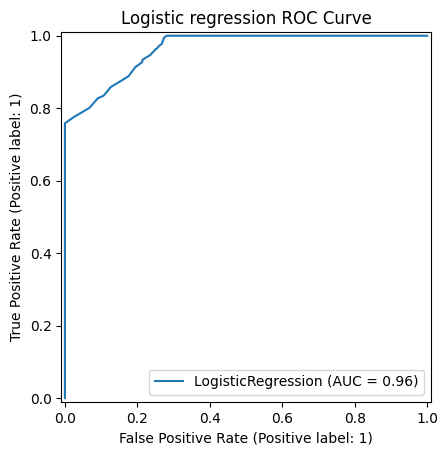

In [245]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("Logistic regression ROC Curve")
plt.show()

In [246]:
# Cross validation

In [247]:
def train(df_train, y_train, C=0.1):
    dicts = df_train[categorical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [248]:
def predict(df, dv, model):
    dicts = df[categorical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [249]:
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.play.values
        y_val = df_val.play.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/6 [00:00<?, ?it/s]

C=0.001 0.956 +- 0.001
C=0.01 0.961 +- 0.001
C=0.1 0.961 +- 0.002
C=0.5 0.962 +- 0.002
C=1 0.962 +- 0.002
C=5 0.961 +- 0.002


In [250]:
## Random forest

In [251]:
# Data preparation for RF

In [252]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [ ]:
# Parameter tuning

In [253]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [254]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

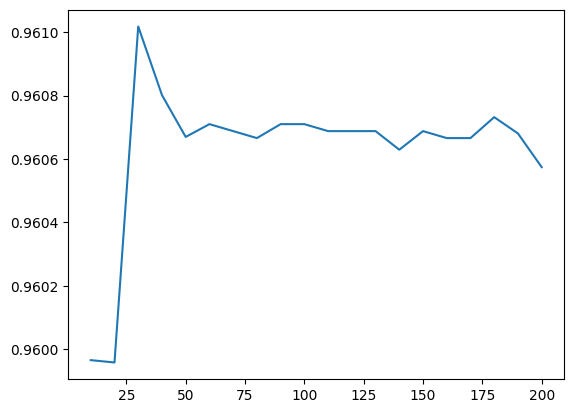

In [255]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [256]:
scores = []

for d in [3, 5, 7]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [257]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

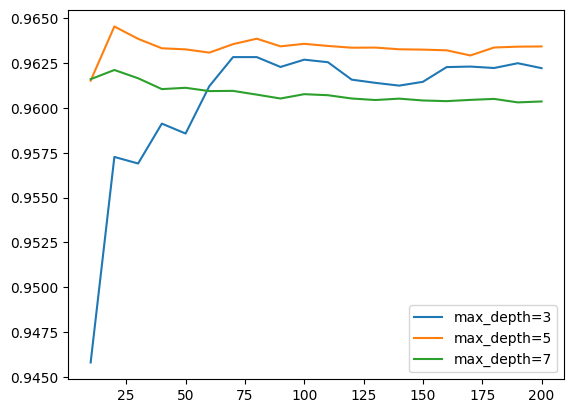

In [258]:
for d in [3, 5, 7]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [260]:
max_depth = 5

In [261]:
scores = []

for s in [5, 10, 20, 30, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [262]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

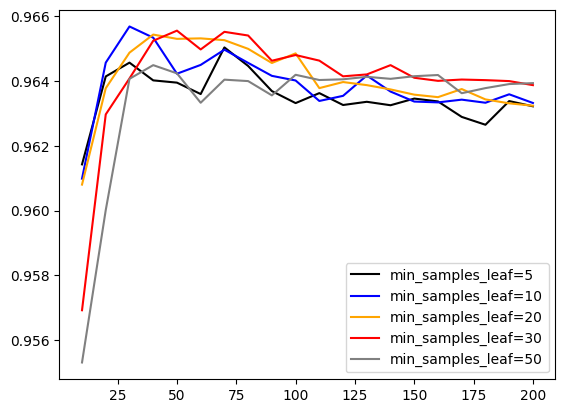

In [263]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [5, 10, 20, 30, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [264]:
min_samples_leaf = 10

In [265]:
# Final RF model

In [266]:
rf = RandomForestClassifier(
    n_estimators=35,
    max_depth=max_depth,
    min_samples_leaf = min_samples_leaf,
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,35
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [267]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest accuracy: 0.8455772113943029
Random Forest ROC-AUC: 0.96403836094973
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       796
           1       0.76      0.91      0.83       538

    accuracy                           0.85      1334
   macro avg       0.84      0.86      0.84      1334
weighted avg       0.86      0.85      0.85      1334



In [373]:
## XGBOOST

In [518]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [275]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [281]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [282]:
s = output.stdout

In [283]:
print(s[:200])

[0]	train-auc:0.96704	val-auc:0.96293
[5]	train-auc:0.96731	val-auc:0.96313
[10]	train-auc:0.96822	val-auc:0.96092
[15]	train-auc:0.96849	val-auc:0.96077
[20]	train-auc:0.96865	val-auc:0.96060
[25]	tr


In [284]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [285]:
df_score = parse_xgb_output(output)

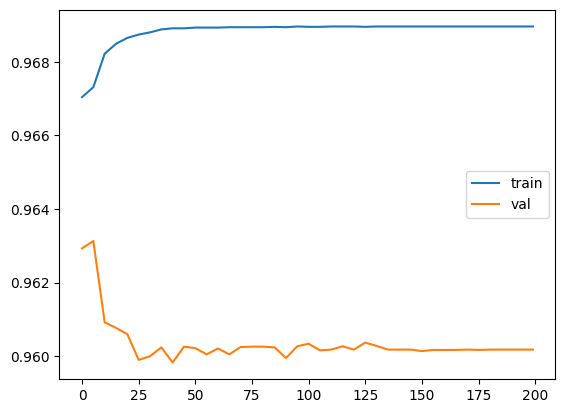

In [286]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

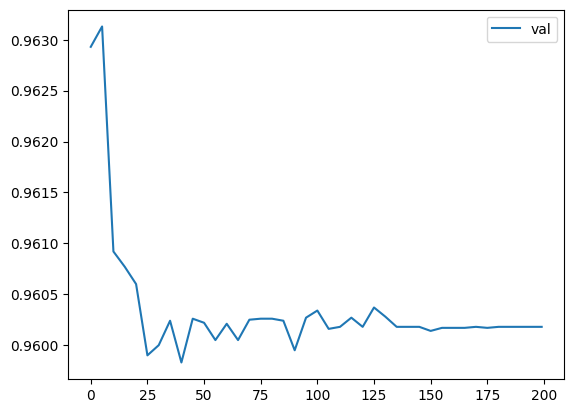

In [287]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [288]:
# Parameter tuning

In [338]:
scores = {} 
etas = [0.01, 0.05, 0.1, 0.3] 

for eta in etas:
    evals_result = {}

    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        evals=watchlist,
        verbose_eval=0,
        num_boost_round=200,
        evals_result=evals_result
    )

    columns = ['iter', 'train_auc', 'val_auc']
    train_aucs = list(evals_result['train'].values())[0]
    val_aucs = list(evals_result['val'].values())[0]

    df_results = pd.DataFrame(
        list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
        columns=columns
    )

    key = f'eta={eta}'
    scores[key] = df_results

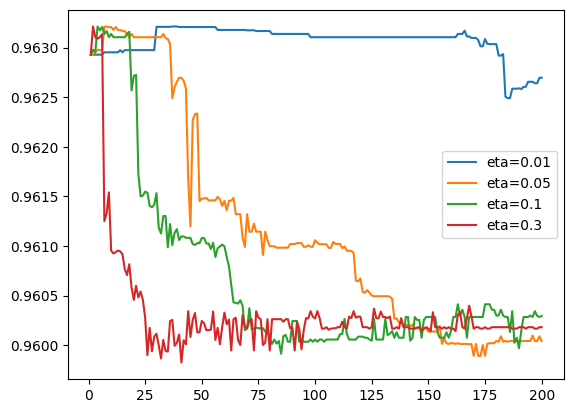

In [342]:
for eta in scores.keys():
    df_results = scores[eta]
    plt.plot(df_results.iter, df_results.val_auc, label=eta)
plt.legend()

In [347]:
eta = 0.01

In [348]:
scores = {} 
max_depths = [4, 5, 6, 7] 

for max_depth in max_depths:
    evals_result = {}

    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        evals=watchlist,
        verbose_eval=0,
        num_boost_round=200,
        evals_result=evals_result
    )

    columns = ['iter', 'train_auc', 'val_auc']
    train_aucs = list(evals_result['train'].values())[0]
    val_aucs = list(evals_result['val'].values())[0]

    df_results = pd.DataFrame(
        list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
        columns=columns
    )

    key = f'max_depth={max_depth}'
    scores[key] = df_results

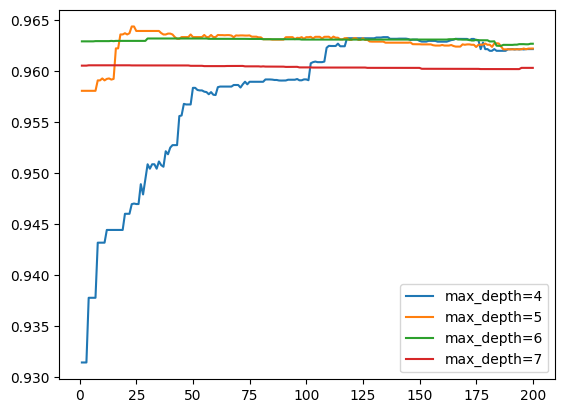

In [349]:
for max_depth in scores.keys():
    df_results = scores[max_depth]
    plt.plot(df_results.iter, df_results.val_auc, label=max_depth)
plt.legend()

In [350]:
max_depth = 5

In [351]:
scores = {} 
min_child_weights = [1, 10, 30] 

for min_child_weight in min_child_weights:
    evals_result = {}

    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        evals=watchlist,
        verbose_eval=0,
        num_boost_round=200,
        evals_result=evals_result
    )

    columns = ['iter', 'train_auc', 'val_auc']
    train_aucs = list(evals_result['train'].values())[0]
    val_aucs = list(evals_result['val'].values())[0]

    df_results = pd.DataFrame(
        list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
        columns=columns
    )

    key = f'min_child_weight={min_child_weight}'
    scores[key] = df_results

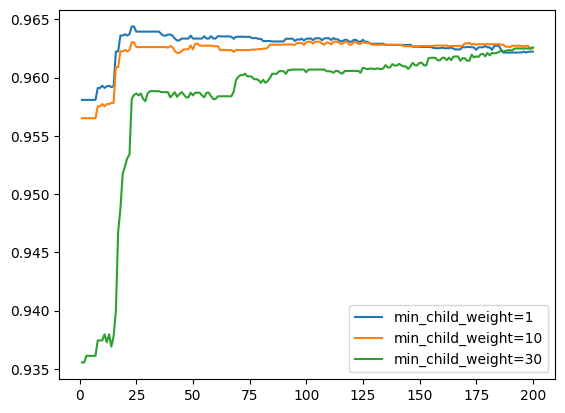

In [352]:
for min_child_weight in scores.keys():
    df_results = scores[min_child_weight]
    plt.plot(df_results.iter, df_results.val_auc, label=min_child_weight)
plt.legend()

In [353]:
min_child_weight = 1

In [354]:
# Final XGBOOST model

In [530]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 5,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=25)

In [531]:
df_score = parse_xgb_output(output)

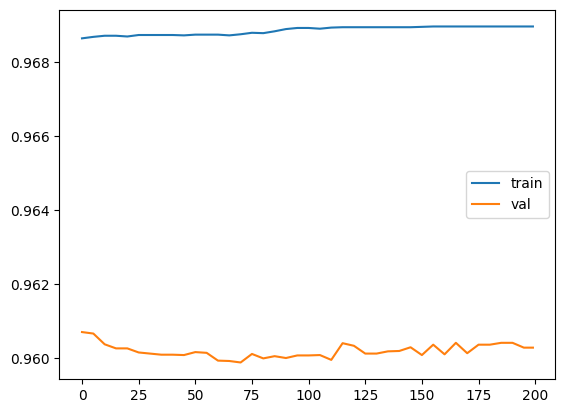

In [532]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [361]:
## Selecting the final model

In [362]:
# Logisting regression

In [364]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

test_dict = df_test[categorical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [366]:
lr = LogisticRegression(solver='liblinear', C=0.1, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [367]:
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9025487256371814
ROC-AUC: 0.9646618314621435

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       796
           1       1.00      0.76      0.86       538

    accuracy                           0.90      1334
   macro avg       0.93      0.88      0.89      1334
weighted avg       0.92      0.90      0.90      1334


Confusion Matrix:
 [[796   0]
 [130 408]]


In [393]:
# Random forest

In [369]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

test_dict = df_test[categorical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [370]:
rf = RandomForestClassifier(
    n_estimators=35,
    max_depth=max_depth,
    min_samples_leaf = min_samples_leaf,
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,35
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [371]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest accuracy: 0.8455772113943029
Random Forest ROC-AUC: 0.96403836094973
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       796
           1       0.76      0.91      0.83       538

    accuracy                           0.85      1334
   macro avg       0.84      0.86      0.84      1334
weighted avg       0.86      0.85      0.85      1334



In [394]:
# XGBOOST

In [505]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [506]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 5,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb = xgb.train(xgb_params, dtrain, num_boost_round=25)

In [507]:
y_pred_xgb = xgb.predict(xtest)

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))

XGBoost ROC-AUC: 0.95647965664755


In [508]:
# Testing on full dataset 

In [541]:
df_full_train = df_full_train.reset_index(drop=True)

In [542]:
y_full_train = (df_full_train.play == 'no').astype(int).values

AttributeError: 'DataFrame' object has no attribute 'play'

In [543]:
del df_full_train['play']

KeyError: 'play'

In [550]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [536]:
features = list(dv.get_feature_names_out())
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=features)

dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [539]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 5,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=25)

XGBoostError: [18:57:06] /workspace/src/objective/regression_obj.cu:119: Check failed: is_valid: base_score must be in (0,1) for the logistic loss.
Stack trace:
  [bt] (0) /usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2bdf8c) [0x70f69d4bdf8c]
  [bt] (1) /usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x1077654) [0x70f69e277654]
  [bt] (2) /usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x1077c75) [0x70f69e277c75]
  [bt] (3) /usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x6d1ab9) [0x70f69d8d1ab9]
  [bt] (4) /usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x6f4db7) [0x70f69d8f4db7]
  [bt] (5) /usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x77) [0x70f69d3caa67]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7b16) [0x70f70b980b16]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x43ef) [0x70f70b97d3ef]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(ffi_call+0x12e) [0x70f70b9800be]



In [528]:
y_pred = model.predict(dtest)

In [529]:
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred))

XGBoost ROC-AUC: 0.9633681885262746


In [561]:
rf = RandomForestClassifier(
    n_estimators=35,
    max_depth=5,
    min_samples_leaf = 10,
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

rf.fit(X_full_train, y_full_train)

,n_estimators,35
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [562]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

IndexError: index 1 is out of bounds for axis 1 with size 1